In [2]:
from environment.models.simple_control import SimpleControlledEnv

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
import random
from collections import namedtuple, deque


2024-03-26 10:29:37.131806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 10:29:37.191939: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
class Agent(object):
    ''' Base agent class, used as a parent class

        Args:
            n_actions (int): number of actions

        Attributes:
            n_actions (int): where we store the number of actions
            last_action (np.array): last action taken by the agent
    '''
    def __init__(self, n_actions: int):
        self.n_actions = n_actions
        self.last_action = None

    def forward(self, state: np.ndarray):
        ''' Performs a forward computation '''
        pass

    def backward(self):
        ''' Performs a backward pass on the network '''
        pass

In [4]:
class RandomAgent(Agent):
    ''' Agent taking actions uniformly at random, child of the class Agent'''
    def __init__(self, n_actions: int):
        super(RandomAgent, self).__init__(n_actions)

    def forward(self, state: np.ndarray) -> int:
        ''' Compute an action uniformly at random across n_actions possible
            choices

            Returns:
                action np.array(int): the random action for each angle
        '''
        action = []
        for i in range(self.n_actions):
            action.append(np.random.randint(-2*np.pi, 2*np.pi))
        self.last_action = np.array(action)
        return self.last_action

Create a class for the experience replay buffer

In [5]:
Experience = namedtuple('Experience',
                        ['state', 'action', 'reward', 'next_state', 'done'])
class ExperienceReplayBuffer(object):
    """ Class used to store a buffer containing experiences of the RL agent.
    """
    def __init__(self, maximum_length):
        # Create buffer of maximum length
        self.buffer = deque(maxlen=maximum_length)
        self.latest_experience = None

    def append(self, experience):
        # Append experience to the buffer
        if(self.latest_experience is not None):
            self.buffer.append(self.latest_experience)

        self.latest_experience = experience

    def __len__(self):
        # overload len operator
        return len(self.buffer)

    def sample_batch(self, n):
        """ Function used to sample experiences from the buffer.
            returns 5 lists, each of size n. Returns a list of state, actions,
            rewards, next states and done variables.
        """
        # If we try to sample more elements that what are available from the
        # buffer we raise an error
        if n > len(self.buffer):
            raise IndexError('Tried to sample too many elements from the buffer!')
        
        # combined experience replay
        # # inclued latest experience in the sampled batch
                    
        batch = random.sample(self.buffer, n - 1)
        batch.append(self.latest_experience)

        # batch is a list of size n, where each element is an Experience tuple
        # of 5 elements. To convert a list of tuples into
        # a tuple of list we do zip(*batch). In this case this will return a
        # tuple of 5 elements where each element is a list of n elements.

        return zip(*batch)

In [6]:
class QNetwork(keras.models.Model):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()

        self.input_layer = keras.layers.Dense(64, activation='relu', input_shape=(input_size,))
        self.hidden_layer1 = keras.layers.Dense(16, activation='relu')
        
        self.hidden_value_layer1 = keras.layers.Dense(128, activation='relu')
        self.hidden_advantage_layer1 = keras.layers.Dense(128, activation='relu')
        self.value_layer = keras.layers.Dense(output_size)
        self.advantage_layer = keras.layers.Dense(output_size)

    def call(self, x):
        _in = keras.layers.ReLU()(self.input_layer(x))
        l1 = keras.layers.ReLU()(self.hidden_layer1(_in))

        v1 = keras.layers.ReLU()(self.hidden_value_layer1(l1))
        v2 = self.value_layer(v1)

        a1 = keras.layers.ReLU()(self.hidden_advantage_layer1(l1))
        a2 = self.advantage_layer(a1)

        q = v2 + a2 - tf.reduce_mean(a2, axis=-1, keepdims=True)
        # print(q.shape)
        return q
    
    def compute_q_values(self, states, actions):
        q_values = self(states)
        selected_q_values = tf.gather(q_values, actions, axis=1)
        return selected_q_values

    def update(self, optimizer, loss_function, predicted_q_values, target_values):
        with tf.GradientTape() as tape:
            loss = loss_function(predicted_q_values, target_values)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss

def epsilon_decay(epsilon_min, epsilon_max, decay_step, k):
    decayed_epsilon = max(epsilon_min, epsilon_max * (epsilon_min / epsilon_max) ** ((k - 1)/(decay_step - 1)))
    return decayed_epsilon

In [7]:
import numpy as np
from itertools import product

controllable_angles = 4

ACTIONS = [-np.pi/4, 0, np.pi/4]

ACTIONS_LIST = np.array(list(product(ACTIONS, repeat=controllable_angles)))
# print(ACTIONS_LIST)
print(ACTIONS_LIST.shape)

n_actions_list = ACTIONS_LIST.shape[0]

(81, 4)


In [8]:
import time

class DQNAgent(Agent):
    def __init__(self, state_size, action_size, replay_length=5000, batch_size=64, gamma=0.99, learning_rate=1e-3, n_episodes=800, epsilon=1.0):
        super(DQNAgent, self).__init__(action_size)
        
        self.learning_rate = learning_rate
        self.n_episodes = n_episodes
        self.episode = 0
        self.epsilon = epsilon
        self.Z = 0.9*self.n_episodes
        self.epsilon_max = 0.99
        self.epsilon_min = 0.05
        
        # step 1:
        ### Create network
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.q_network = self._build_network(state_size, action_size)
        self.target_network = self._build_network(state_size, action_size)
        self.target_network.set_weights(self.q_network.get_weights())
        self.q_network.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
        
        # step 2:
        ### Create Experience replay buffer
        self.buffer = ExperienceReplayBuffer(maximum_length=replay_length)
        self.batch_size = batch_size
        self.gamma = gamma
        
        ### Agent init
        self.state_size = state_size
        self.action_size = action_size
        
        ### Steps
        self.target_update_rate = int(replay_length/batch_size) # suggested as tip
        self.steps = 0  # Counter for steps taken
        
    def _build_network(self, state_size, action_size):
        # model = keras.models.Sequential()
        # model.add(keras.layers.Dense(24, input_dim=state_size, activation='relu'))
        # model.add(keras.layers.Dense(24, activation='relu'))
        # model.add(keras.layers.Dense(action_size, activation='linear'))
        # model.compile(loss='mse', optimizer=self.optimizer)
        return QNetwork(state_size, action_size)

    def forward(self, state):
        # make sure state is of correct shape
        state = state.reshape(1, -1)
        
        # step 7:
        # take epsilon-greedy action a_t at s_t     
        
        if random.random() < self.epsilon:
            self.epsilon = max(self.epsilon_min, self.epsilon_max * (self.epsilon_min/self.epsilon_max) ** ((self.episode - 1)/(self.Z - 1)))
            return np.random.choice(range(len(ACTIONS_LIST)))

        q = self.q_network.call(state)
        
        self.epsilon = max(self.epsilon_min, self.epsilon_max * (self.epsilon_min/self.epsilon_max) ** ((self.episode - 1)/(self.Z- 1)))

        # Return the index of the action with the highest Q-value for each angle, as an array
        # print("Q SHAPE: " + str(q.shape))
        return np.argmax(q)
     
    def sample(self, state):
        if not isinstance(state[0], np.float32):
            state = np.array(state[0])
        q = self.q_network.call(state)
        return np.argmax(q)

    # def backward(self):
    #     if len(self.buffer.buffer) < self.batch_size:
    #         return
        
    #     # step 9:
    #     # Sample a batch of experiences from the buffer
    #     batch = Experience(*self.buffer.sample_batch(self.batch_size))        
    #     batch_mask = ~np.array(batch.done, dtype=bool)

    #     next_state = np.stack(batch.next_state)
    #     states = np.stack(batch.state)
    #     actions = np.stack(batch.action)
    #     rewards = np.concatenate(batch.reward)        

    #     # step 10:
    #     # Compute target values for each experience in the batch
    #     target_values = np.zeros((next_state.shape[0], 1), dtype=np.float32)

    #     a_star = tf.argmax(self.q_network.call(next_state), axis=1)
    #     index_tensor = tf.range(len(a_star), dtype=tf.int64)
        
    #     indices = tf.stack([index_tensor, a_star], axis=1)
    #     _1 = tf.gather_nd(self.target_network.call(next_state), indices)
    #     _1 = tf.boolean_mask(_1, batch_mask)
    #     _1 = tf.expand_dims(_1, axis=1)
    #     # _1 = tf.reshape(_1, (-1, 1))
    #     target_values[batch_mask] = _1
    #     target_values = rewards + self.gamma * target_values.squeeze(1)

    #     # step 11:
    #     # Compute predicted Q-values for the states and actions in the batch
    #     predicted_q_values = self.q_network.call(states)
        
    #     # Reshape predicted_q_values to match the shape of actions
    #     predicted_q_values = tf.reshape(predicted_q_values, (-1, self.action_size))
    #     # Use actions to index predicted_q_values
    #     # Create an array of batch indices
    #     batch_indices = np.arange(self.batch_size)

    #     # Stack the batch indices and action indices
    #     actions = actions_to_index(actions)
    #     indices = np.stack([batch_indices, actions], axis=1)
    #     predicted_q_values = tf.gather_nd(predicted_q_values, indices)

    #     # Update Q-network weights using the computed values
    #     self.q_network.fit(states, target_values, epochs=1, verbose=0)

    #     # step 12:
    #     # Implement the target network update if C steps have passed (Step 12)
    #     if self.steps % self.target_update_rate == self.target_update_rate - 1:
    #         self.target_network.set_weights(self.q_network.get_weights())

    #     # step 13:
    #     # Increment steps counter
    #     self.steps += 1
    def backward(self):
        # start_time = time.time()

        if len(self.buffer.buffer) < self.batch_size:
            return

        # step 9:
        # Sample a batch of experiences from the buffer
        # t0 = time.time()
        batch = Experience(*self.buffer.sample_batch(self.batch_size))        
        batch_mask = ~np.array(batch.done, dtype=bool)
        # print(f"Time taken in step 9: {time.time() - t0} seconds")

        next_state = np.stack(batch.next_state)
        states = np.stack(batch.state)
        actions = np.stack(batch.action)
        rewards = np.concatenate(batch.reward)        

        # step 10:
        # Compute target values for each experience in the batch
        # t0 = time.time()
        # target_values = np.zeros((next_state.shape[0], 1), dtype=np.float32)
        # a_star = tf.argmax(self.q_network.call(next_state), axis=1)
        # index_tensor = tf.range(len(a_star), dtype=tf.int64)
        # indices = tf.stack([index_tensor, a_star], axis=1)
        # _1 = tf.gather_nd(self.target_network.call(next_state), indices)
        # _1 = tf.boolean_mask(_1, batch_mask)
        # _1 = tf.expand_dims(_1, axis=1)
        # target_values[batch_mask] = _1
        # target_values = rewards + self.gamma * target_values.squeeze(1)
        # Compute Q-values for the next states using the Q-network
        q_values_next_state = self.q_network(next_state)

        # Compute the indices of the maximum Q-values
        max_q_indices = tf.argmax(q_values_next_state, axis=1)

        # Use these indices to compute the corresponding Q-values using the target network
        target_q_values_next_state = self.target_network(next_state)
        max_target_q_values = tf.gather_nd(target_q_values_next_state, tf.stack([tf.range(len(max_q_indices), dtype=tf.int64), max_q_indices], axis=1))

        # Compute the target values
        target_values = rewards + self.gamma * tf.where(batch_mask, max_target_q_values, 0)
        # print(f"Time taken in step 10: {time.time() - t0} seconds")

        # step 11:
        # Compute predicted Q-values for the states and actions in the batch
        # t0 = time.time()
        predicted_q_values = self.q_network.call(states)

        batch_indices = tf.range(self.batch_size)
        # actions = actions_to_index(actions)
        # print(actions.shape, batch_indices.shape)
        indices = tf.stack([batch_indices, actions], axis=1)
        # print(indices.shape)
        # print(predicted_q_values.shape)
        predicted_q_values = tf.gather_nd(predicted_q_values, indices)
        # print(f"Time taken in step 11: {time.time() - t0} seconds")

        # Update Q-network weights using the computed values
        # t0 = time.time()
        self.q_network.fit(states, target_values, epochs=1, verbose=0)
        # print(f"Time taken in Q-network update: {time.time() - t0} seconds")

        # step 12:
        # Implement the target network update if C steps have passed (Step 12)
        # t0 = time.time()
        if self.steps % self.target_update_rate == self.target_update_rate - 1:
            self.target_network.set_weights(self.q_network.get_weights())
        # print(f"Time taken in step 12: {time.time() - t0} seconds")

        # step 13:
        # Increment steps counter
        # t0 = time.time()
        self.steps += 1
        # print(f"Time taken in step 13: {time.time() - t0} seconds")

        # print(f"Total time taken: {time.time() - start_time} seconds")

In [9]:
def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y


def faster_running_average(x, N, last_average):
    if len(x) > N:
        return last_average + (1./N)*(x[-1] - x[-N - 1])
    else:
        return sum(x)/len(x)

In [10]:
# Parameters
N_episodes = 1000                           # Number of episodes # 100 - 1000
discount_factor = 0.99                      # Value of the discount factor
n_ep_running_average = 50                   # Running average of 50 episodes
n_actions = n_actions_list                   # Number of available actions
dim_state = 2                              # State dimensionality
replay_size = 5000                          # 5000 - 30000
batch_size = 64                              # 4 - 128
learning_rate = 1e-4                         # 1e-3 - 1e-4
target_reward = 0                               # specified in lab
max_env_steps = 1000                          # to stop the episode

# We will use these variables to compute the average episodic reward and
# the average number of steps per episode
episode_reward_list = []       # this list contains the total reward per episode
episode_number_of_steps = []   # this list contains the number of steps per episode

# agent initialization
# agent = RandomAgent(n_actions) # random
# step 1 & 2:
agent = DQNAgent(dim_state, n_actions, replay_size, batch_size=batch_size, gamma=discount_factor, learning_rate=learning_rate, n_episodes=N_episodes, epsilon=1.0)

2024-03-26 10:29:38.133397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
env = SimpleControlledEnv()

In [12]:
### Training process
from tqdm import trange
# trange is an alternative to range in python, from the tqdm library
# It shows a nice progression bar that you can update with useful information
EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
actual_episodes = 0

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
# import time

avg_reward = 0.
avg_steps = 0.
# step 3:
# episode loop
for i in EPISODES:
    # Reset environment data and initialize variables
    done = False
    # step 4:
    state = env.reset()
    state = np.array(state, dtype=np.float32)
 
    total_episode_reward = 0.
    # step 5:
    t = 0
    # step 6: 
    # environment loop
    while not done:
        # start_time = time.time()
        # step 7:
        # epsilon-greedy action
        action_index = agent.forward(state)
        action = ACTIONS_LIST[action_index]
        # print("network action")

        # forward_time = time.time()
        # print(f'Time taken in forward: {forward_time - start_time} seconds')

        # print(f"true action: {action}")

        # Get next state and reward. The done variable
        # print(f"PUMP ACTION: {action[0:4]}")
        # print(f"ALICE ACTION: {action[4:8]}")
        # print(action)
        next_state, reward, done = env.step(a_alice=action[0:4])

        next_state = np.array(next_state, dtype=np.float32)
        
        # step_time = time.time()
        # print(f'Time taken in step: {step_time - forward_time} seconds')

        # append to buffer
        agent.buffer.append(Experience(state, action_index, np.array([reward], dtype=np.float32), next_state, done))
            
        agent.backward()
        
        # backward_time = time.time()
        # print(f'Time taken in backward: {backward_time - step_time} seconds')

        # Update episode reward
        total_episode_reward += reward

        # Update state for next iteration
        state = next_state
        t += 1
        # loop_time = time.time()
        # print(f'Total time taken in loop: {loop_time - start_time} seconds')

    # Append episode reward and total number of steps
    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)

    avg_reward = faster_running_average(episode_reward_list, n_ep_running_average, avg_reward)
    avg_steps = faster_running_average(episode_number_of_steps, n_ep_running_average, avg_steps)

    agent.episode += 1

    # Updates the tqdm update bar with fresh information
    # (episode number, total reward of the last episode, total number of Steps
    # of the last episode, average reward, average number of steps)
    EPISODES.set_description(
        "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{:.1f}".format(
        i, total_episode_reward, t,
        avg_reward,
        avg_steps)
        )

    actual_episodes += 1
    
    # stop if we hit reward threshold
    if avg_reward >= target_reward:
        break

Episode 120 - Reward/Steps: -222.0/500 - Avg. Reward/Steps: -221.9/500.0:  12%|█▏        | 121/1000 [41:06<5:28:29, 22.42s/it]

: 

# TEST ENV

In [ ]:
env = SimpleControlledEnv()
steps = 1000

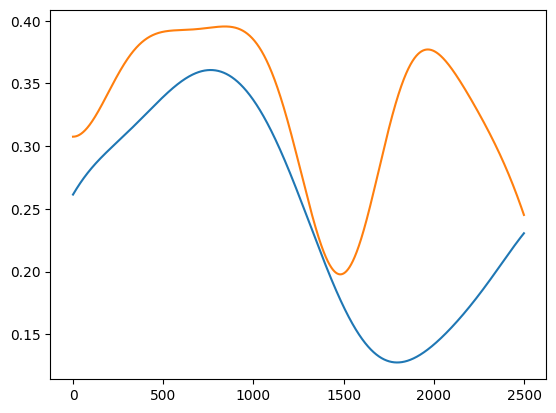

In [ ]:
for i in range(steps):
    env.step(a_pump=[0, 0, 0, 0], a_alice=[0, 0, 0, 0])
    
# plot QBER
plt.plot(env.get_QBER())